In [12]:
%pylab inline
import numpy as np
import scipy as sc
import pandas as pd

import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("talk")
#rc('axes', labelsize=20, titlesize=20)

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy.stats as ss

from ABC_algorithm import ABC 
from post_adjustment import PostProcess

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Normal example

[(0.89411765336990356, 0.10196078568696976, 0.1098039224743836),
 (0.21602460800432688, 0.49487120380588578, 0.71987698697576341),
 (0.30426760128900115, 0.68329106055054012, 0.29293349969620797),
 (0.60083047361934894, 0.30814303335021531, 0.63169552298153153),
 (1.0, 0.50591311045721454, 0.0031372549487094226),
 (0.99315647868549106, 0.98700499826786559, 0.19915417450315831),
 (0.65845446095747096, 0.34122261685483596, 0.17079585352364723),
 (0.95850826852461857, 0.50846600392285535, 0.7449288887136124),
 (0.60000002384185791, 0.60000002384185791, 0.60000002384185791)]

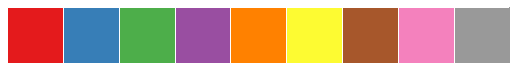

In [77]:
sns.set_palette("Set1")
sns.choose_colorbrewer_palette("qualitative")

In [84]:
######
# set up for the normal ABC example
######

prior_mean = -2.0
prior_sd = 1
likelihood_sd = 1

def NormalPriorSampler(n):
    return np.random.normal(loc=prior_mean, scale=prior_sd, size=n)

def NormalLiklihoodSimulator(n, param):
    #unknown mean
    return np.random.normal(loc=param, scale=likelihood_sd, size=n)
    
def NormalSummary(data):
    return np.mean(data, axis=0)

data = np.random.normal(loc=0,scale=likelihood_sd,size=200)

post_sd = np.power((1.0/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2)),-1/2)
post_mean = (prior_mean/np.power(prior_sd,2) + np.sum(data)/(np.power(likelihood_sd,2)))/(1/np.power(prior_sd,2) + len(data)/np.power(likelihood_sd,2))
print post_mean, "is posterior mean"
print post_sd, "is posterior std dev"

-0.101707636225 is posterior mean
0.00497512437811 is posterior std dev



## Run ABC for the normal example


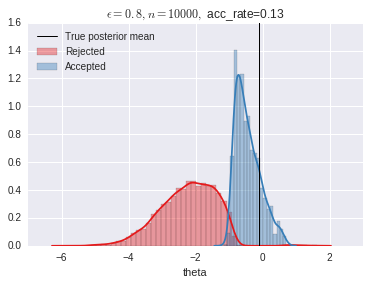

In [135]:
epsilon = 0.8
n = 10000
df = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, epsilon, data , n)

######
# plot the accepted and rejected params
######

fig, ax = plt.subplots()

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept,sub_df in df.groupby('accept'):
    sns.distplot(sub_df.theta, ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

acc_rate = round(float(len(df[df.accept == 1].index))/float(len(df.index)),2)

plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.legend(loc='upper left')
plt.title(r'$\epsilon = {}, n={}, $ acc_rate={}'.format(epsilon,n,acc_rate))
plt.savefig('plots/1d_normal_abc_report_epsilon_{}.pdf'.format(epsilon))

##Compare with and w/o post processing

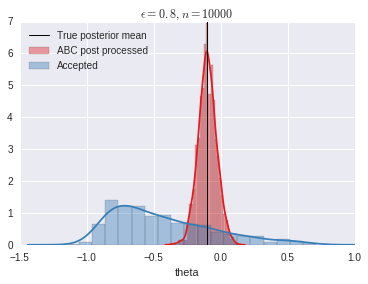

In [136]:
df_abc_accepted_post_processed = PostProcess(df, NormalSummary, data, weighted=True)

df_abc_accepted = df[df.accept == 1]

fig, ax = plt.subplots()

sns.distplot(df_abc_accepted_post_processed.theta_star, ax=ax, kde = True, label='ABC post processed')

accept_legend_map = {1:'Accepted',0:'Rejected'}
for accept,sub_df in df.groupby('accept'):
    if accept==1:
        sns.distplot(sub_df.theta, ax=ax, kde = True, label=accept_legend_map[accept]) #norm_hist =True,

plt.axvline(x=post_mean, ymin=0, ymax = 120, linewidth=1, color='k', label='True posterior mean')
plt.title(r'$\epsilon = {}, n={}$'.format(epsilon,n,acc_rate))
plt.legend(loc='upper left')
plt.savefig('plots/1d_normal_abc_report_postadj_epsilson_{}.pdf'.format(epsilon))

## Evaluate MSE with varying $\epsilon$

In [81]:
epsilon_count = 50
epsilon = 0
epsilon_increment = 0.2

k = 10
n = 10000

def calc_error(dist_from_truth, abc_post_means, epsilon, error_epsilon_list):
    #print dist_from_truth
    squared_dist_from_truth = np.power(dist_from_truth,2)
    mse = np.mean(squared_dist_from_truth)
    mse_err = 1.96*np.std(squared_dist_from_truth)

    mc_bias = np.mean(dist_from_truth)
    mc_bias_err = 1.96*np.std(dist_from_truth)

    var = np.var(abc_post_means)

    mse_check = np.add(var, np.power(mc_bias,2))

    error_epsilon_list.append({'epsilon':epsilon,
                               'bias':mc_bias, 'bias_err':mc_bias_err, 
                               'mse':mse, 'mse_err':mse_err,
                               'var':var,
                               'mse_check':mse_check
                              })
    return error_epsilon_list


error_epsilon_list = []
pp_error_epsilon_list = []

for e in range(epsilon_count):
    epsilon = epsilon + epsilon_increment
    
    #print "epsilon:{}".format(epsilon)

    abc_post_means = []
    pp_abc_post_means = []
    dist_from_truth = []
    pp_dist_from_truth = []

    for i in range(k):
        ## we will do abc k times for each epsilon
        # print "Iteration:{}".format(i)
        df_ei = ABC(NormalPriorSampler, NormalLiklihoodSimulator, NormalSummary, epsilon, data, n)
    
        df_abc_accepted = df_ei[df_ei.accept == 1]
        count_accepted = len(df_abc_accepted.index)
        #print count_accepted
        if count_accepted < 20:
            #print "Not doing post adjustment"
            pp_abc_post_means.append(np.nan)
            pp_dist_from_truth.append(np.nan)
        else:
            ## also post process the ABC output
            df_abc_accepted_post_processed = PostProcess(df_ei, NormalSummary, data, weighted=True)
            #df_abc_accepted_post_processed = df_ei
            pp_abc_post_mean = df_abc_accepted_post_processed.theta_star.mean()
            pp_abc_post_means.append(pp_abc_post_mean)
            pp_dist_from_truth.append(abs(pp_abc_post_mean - post_mean))

            ## store k abc posterior means w and w/out post processing (pp)
        abc_post_mean = df_abc_accepted.theta.mean()
        abc_post_means.append(abc_post_mean)
        ## and store dist of this from truth
        dist_from_truth.append(abs(abc_post_mean - post_mean))
        
    error_epsilon_list = calc_error(dist_from_truth, abc_post_means, epsilon, error_epsilon_list)
    pp_error_epsilon_list = calc_error(pp_dist_from_truth, pp_abc_post_means, epsilon, pp_error_epsilon_list)

    
mse_df = pd.DataFrame(error_epsilon_list)
pp_mse_df = pd.DataFrame(pp_error_epsilon_list)

In [82]:
print mse_df.head()
print pp_mse_df.head()

       bias  bias_err  epsilon       mse  mse_check   mse_err       var
0  0.026817  0.022489      0.2  0.000851   0.000851  0.001311  0.000132
1  0.099019  0.013165      0.4  0.009850   0.009850  0.002587  0.000045
2  0.198695  0.021100      0.6  0.039595   0.039595  0.008504  0.000116
3  0.337591  0.021732      0.8  0.114091   0.114091  0.014738  0.000123
4  0.480400  0.015818      1.0  0.230849   0.230849  0.015328  0.000065
       bias  bias_err  epsilon       mse  mse_check   mse_err       var
0  0.003310  0.006406      0.2  0.000022   0.000029  0.000061  0.000018
1  0.003664  0.003048      0.4  0.000016   0.000028  0.000023  0.000014
2  0.003526  0.006532      0.6  0.000024   0.000033  0.000067  0.000021
3  0.004314  0.007096      0.8  0.000032   0.000050  0.000079  0.000032
4  0.004470  0.004291      1.0  0.000025   0.000045  0.000040  0.000025


##Plot some errors w/ $\epsilon$

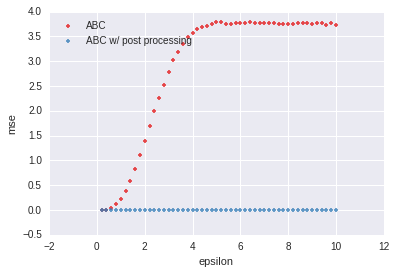

In [93]:
sns.regplot(x=mse_df.epsilon, y=mse_df.mse, marker="+", fit_reg=False, label='ABC')
sns.regplot(x=pp_mse_df.epsilon, y=pp_mse_df.mse, marker="+", fit_reg=False, label='ABC w/ post processing')
#plt.errorbar(x=mse_df.epsilon, y=mse_df.mse, yerr=mse_df.mse_err, linestyle="None")
#plt.savefig('plots/1d_normal_mse_epsilon_k{}_n{}_.pdf'.format(k,n))
plt.legend(loc='upper left')

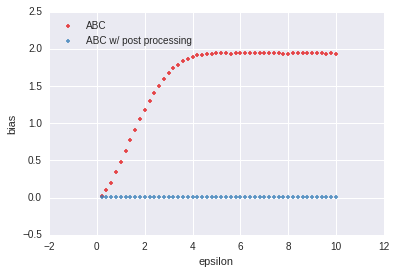

In [94]:
sns.regplot(x=mse_df.epsilon, y=mse_df.bias, marker="+", fit_reg=False, label='ABC')
sns.regplot(x=pp_mse_df.epsilon, y=pp_mse_df.bias, marker="+", fit_reg=False, label='ABC w/ post processing')
#plt.errorbar(x=mse_df.epsilon, y=mse_df.bias, yerr=mse_df.bias_err, linestyle="None")
#plt.savefig('plots/1d_normal_bias_epsilon_k{}_n{}_.pdf'.format(k,n))
plt.legend(loc='upper left')

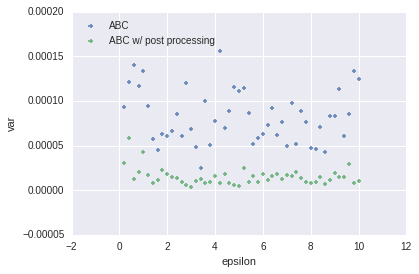

In [53]:
sns.regplot(x=mse_df.epsilon, y=mse_df['var'], marker="+", fit_reg=False, label='ABC')
sns.regplot(x=pp_mse_df.epsilon, y=pp_mse_df['var'], marker="+", fit_reg=False, label='ABC w/ post processing')
#plt.errorbar(x=mse_df.epsilon, y=mse_df.bias, yerr=mse_df.bias_err, linestyle="None")
#plt.savefig('plots/1d_normal_var_epsilon_k{}_n{}_.pdf'.format(k,n))
plt.legend(loc='upper left')